In [ ]:
!pip install catboost -q

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os
import json
from tqdm.notebook import tqdm

import catboost

pd.set_option('max_columns', None)

In [ ]:
def read_json(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return json.load(f)


def read_json_to_pd(filename):
    '''
    read json file
    '''
    with open(filename, 'r', encoding='utf-8') as f:
        return pd.read_json(f)

## Генерация признаков и их предобработка


1.   Убрать \" из текста
2.   Разделить каждую дату на 3 признака
3.   Признак кол-ва поставленных задач
4.   Бинарный признак - наличие сайта
5.   Есть ли на сайте ssl
6.   Признак кол-ва таргет групп
7.   Распорсить ОГРН



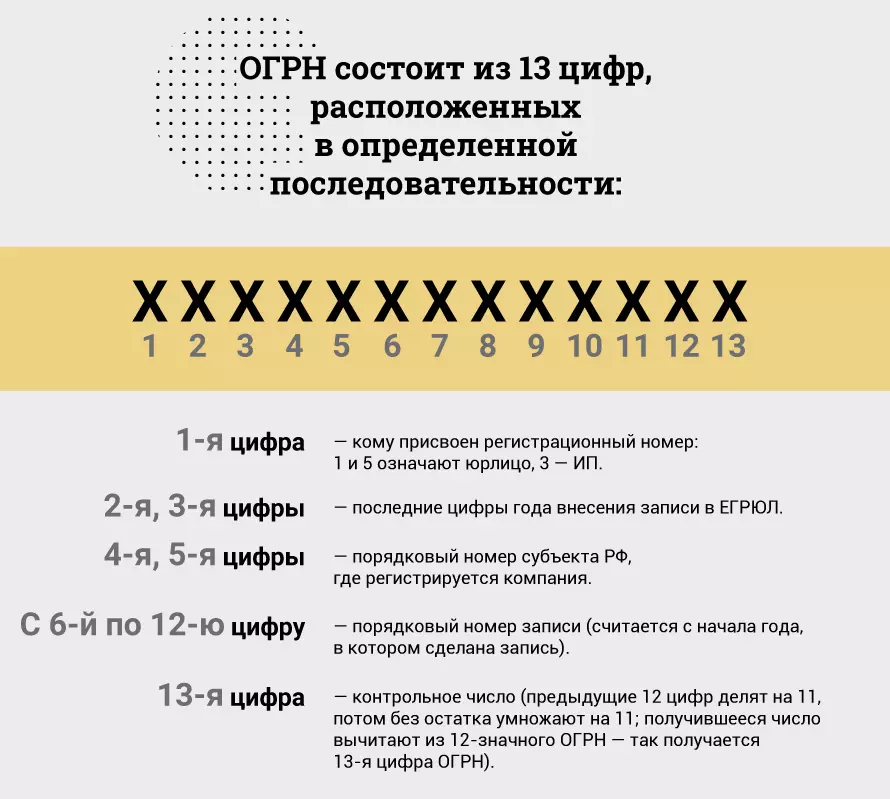

In [ ]:
JSON_PATH = '/content/drive/MyDrive/grant_analysis/data/active_data_g.json'

In [ ]:
df = read_json_to_pd(JSON_PATH)

In [ ]:
df.describe()

,requested_amount,co_financing,amount_of_costs,application_rating,inn,ogrn,index
count,9.740000e+03,9.740000e+03,9.740000e+03,1883.000000,9.740000e+03,9.740000e+03,9740.000000
mean,2.656945e+06,1.584341e+06,3.843294e+06,69.668688,4.792863e+09,1.136489e+12,4869.500000
std,6.734203e+06,6.196357e+06,1.181369e+07,4.873474,2.616964e+09,6.378934e+10,2811.840145
min,2.750000e+04,0.000000e+00,3.290000e+04,60.000000,1.040152e+08,1.020100e+12,0.000000
25%,4.998665e+05,2.608750e+05,8.471300e+05,66.500000,2.536315e+09,1.086100e+12,2434.750000
50%,1.451546e+06,6.575970e+05,1.905275e+06,69.250000,5.029071e+09,1.155749e+12,4869.500000
75%,2.977796e+06,1.553168e+06,4.200061e+06,72.500000,7.325021e+09,1.191356e+12,7304.250000
max,3.476733e+08,4.737242e+08,8.213975e+08,91.750000,9.901037e+09,1.227700e+12,9739.000000


In [ ]:
def drop_trash_fetures(df,trash_list: list):
    '''
    '''

    df = df.copy()

    return df.drop(columns=trash_list)


def parse_ogrn_info(df):
    '''
    '''
    df = df.copy()
    # разбиение огрн на 5 пуллов
    ogrn_spit = [[0,1],[1,3],[3,5],[5,-1],[12,13]]

    print('Ogrn parsing...')
    i=0 # для нормально работы tqdm

    for split in tqdm(ogrn_spit):
        df[f'ogrn_{i}'] = df['ogrn'].apply(lambda x: pd.Series(int(str(x)[split[0]:split[1]])))
        i+=1
    print('Ogrn was parsed successfully!')

    return df


def encode_datetime(df,datetime_features: list):
    '''
    кодировка дат на год, квартал, месяц
    в качестве новых признаков
    '''

    df=df.copy()
    print('Datetime features converting...')
    df[datetime_features] = df[datetime_features].apply(pd.to_datetime)
    for d_feture in tqdm(datetime_features):
        df[f'{d_feture}_year'] = df[d_feture].dt.year
        df[f'{d_feture}_quarter'] = df[d_feture].dt.quarter
        df[f'{d_feture}_month'] = df[d_feture].dt.month
        df[f'{d_feture}_dayofyear'] = df[d_feture].dt.dayofyear

    df=df.drop(columns=datetime_features)
    print('Datetime features converted!')

    return df


def site_checker(x):
    '''
    Ранжирование ссылок на проекты

    сайта нет   - 0
    сайт http  - 1
    сайт https - 2
    '''
    
    if x:
        if x.split(':')[0][-1]=='s':
            return 2
        else:
            return 1
    else:
        return 0


def website_encoding(df):
    '''
    '''

    df = df.copy()
    df['website_link'] = df['website_link'].apply(site_checker)
    print('Website features converted!')
    return df

def prepare_list_of_str(df, list_of_str):
    '''
    '''
    df = df.copy()

    for el in list_of_str:
        df[f'{el}_len'] = df[el].apply(lambda x: len(x))
        df[el] = df[el].apply(lambda x: ''.join(x))

    return df

def target_encoding(df, target_enc: dict):
    '''
    кодирование целевой переменной
    в соотвествии с переданным словарем
    '''
    df = df.copy()

    return df.replace(target_enc)


In [ ]:
trash_list = ['index','inn','ogrn_0','application_number','location','application_number','amount_of_costs']
datetime_features = ['date_of_submission','implementation_period_start','implementation_period_end']
list_of_str = ['tasks','target_groups']
target_enc = {
                'status':{  'победитель конкурса': 1,
                            'проект не получил поддержку': 0,
                            'на независимой экспертизе':-1
                          }
                }

In [ ]:
%%time
new_df = (df.pipe(parse_ogrn_info)\
            .pipe(encode_datetime,datetime_features)\
            .pipe(website_encoding)\
            .pipe(drop_trash_fetures,trash_list)\
            .pipe(prepare_list_of_str, list_of_str)\
            .pipe(target_encoding,target_enc)
            )

Ogrn parsing...


  0%|          | 0/5 [00:00<?, ?it/s]

Ogrn was parsed successfully!
Datetime features converting...


  0%|          | 0/3 [00:00<?, ?it/s]

Datetime features converted!
Website features converted!
CPU times: user 14.8 s, sys: 128 ms, total: 14.9 s
Wall time: 19.9 s


In [ ]:
new_df.filter(regex='ogrn_*', axis=1)

,ogrn,ogrn_1,ogrn_2,ogrn_3,ogrn_4
0,1215500017347,21,55,1734,7
1,1082300002201,8,23,220,1
2,1023100015366,2,31,1536,6
3,1023100015366,2,31,1536,6
4,1195275053093,19,52,7505309,3
...,...,...,...,...,...
9735,1203700002131,20,37,213,1
9736,1187800004336,18,78,433,6
9737,1207700468140,20,77,46814,0
9738,1147800002987,14,78,298,7


In [ ]:
new_df.isna().mean().sort_values(ascending=False)

application_rating                       0.806674
implementation_period_start_month        0.000411
implementation_period_end_dayofyear      0.000411
implementation_period_end_month          0.000411
implementation_period_end_quarter        0.000411
implementation_period_end_year           0.000411
implementation_period_start_dayofyear    0.000411
implementation_period_start_quarter      0.000411
implementation_period_start_year         0.000411
date_of_submission_month                 0.000000
ogrn_4                                   0.000000
date_of_submission_year                  0.000000
date_of_submission_quarter               0.000000
title                                    0.000000
date_of_submission_dayofyear             0.000000
ogrn_2                                   0.000000
tasks_len                                0.000000
ogrn_3                                   0.000000
ogrn_1                                   0.000000
status                                   0.000000


In [ ]:
new_df['status'].value_counts()

 0    7596
 1    1883
-1     261
Name: status, dtype: int64

In [ ]:
new_df['grant_direction'].value_counts()

Социальное обслуживание, социальная поддержка и защита граждан                                                                                                                                2722
Охрана здоровья граждан, пропаганда здорового образа жизни                                                                                                                                    1442
Поддержка проектов в области науки, образования, просвещения                                                                                                                                  1177
Сохранение исторической памяти                                                                                                                                                                1077
Поддержка семьи, материнства, отцовства и детства                                                                                                                                              865
Поддержка молодежных прое

In [ ]:
new_df

,title,status,requested_amount,co_financing,competition,grant_direction,application_rating,organization,ogrn,aim,tasks,target_groups,project_geography,social_significance,website_link,addres,summary,ogrn_1,ogrn_2,ogrn_3,ogrn_4,date_of_submission_year,date_of_submission_quarter,date_of_submission_month,date_of_submission_dayofyear,implementation_period_start_year,implementation_period_start_quarter,implementation_period_start_month,implementation_period_start_dayofyear,implementation_period_end_year,implementation_period_end_quarter,implementation_period_end_month,implementation_period_end_dayofyear,tasks_len,target_groups_len
0,Женский хоккейный клуб,1,495153.4,846543.4,Второй конкурс 2022,"Охрана здоровья граждан, пропаганда здорового ...",74.0,ОМСКАЯ РЕГИОНАЛЬНАЯ ОБЩЕСТВЕННАЯ ОРГАНИЗАЦИЯ '...,1215500017347,Создать условия для организации тренировочного...,Организовать для девушек -хоккеисток старше 16...,"Девушки - хоккеистки г.Омска 16-25 лет, желающ...",г.Омск,"Девочки 1-3 класса , которые хотят играть в хо...",2,"Омская обл, г Омск, Кировский округ, ул Крупск...",В Омске с 2018 года реализуется проект по разв...,21,55,1734,7,2022,1,3,73,2022.0,1.0,1.0,9.0,2023.0,2.0,5.0,150.0,2,2
1,Креативность против стресса: эмоциональная под...,0,1376320.0,660957.0,Второй конкурс 2022,"Социальное обслуживание, социальная поддержка ...",NaN,НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ БЛАГОТВОРИТЕЛЬНЫЙ Ф...,1082300002201,Содействовать повышению уровня стрессоустойчив...,Передать представителям целевой аудитории знан...,Слабовидящие и незрячие люди,Мероприятия проекта пройдут в городах: г. Брян...,По данным Пенсионного фонда РФ и Росстата РФ в...,1,"350000, Краснодарский край, г Краснодар, ул Се...","Проект ""Креативность против стресса"" направлен...",8,23,220,1,2022,1,3,73,2022.0,1.0,1.0,7.0,2023.0,2.0,6.0,153.0,3,1
2,РазУмным людям - разУмные игры,0,745710.0,621200.0,Второй конкурс 2022,"Поддержка молодежных проектов, реализация кото...",NaN,ПЕРВИЧНАЯ ОРГАНИЗАЦИЯ БЕЛГОРОДСКОЙ ОБЛАСТНОЙ О...,1023100015366,Интеллектуальное развитие молодежи путем созда...,Создать материально-техническую базу и развить...,молодежь от 14 до 30,"Томаровская и Гостищевская территории, г. Стро...","Проблема, решаемая в проекте - отток молодежи ...",0,"Белгородская обл, Яковлевский р-н, г Строитель...",В рамках реализации проекта в двух крупных сел...,2,31,1536,6,2022,1,3,74,2022.0,1.0,1.0,7.0,2023.0,2.0,6.0,181.0,3,1
3,AРТ-бульвар PROСвет,0,1028869.0,515300.5,Второй конкурс 2022,"Поддержка проектов в области науки, образовани...",NaN,ПЕРВИЧНАЯ ОРГАНИЗАЦИЯ БЕЛГОРОДСКОЙ ОБЛАСТНОЙ О...,1023100015366,Содействие в формировании уличного городского ...,создание условий для творческой самореализации...,"Жители и гости г. СтроительХудожники, поэты, м...","Белгородская область, Яковлевский городской ок...",Культурное пространство является неотъемлемой ...,0,"309070, Белгородская обл, Яковлевский р-н, г С...",Проект «АРТ – бульвар PROСвет» призван способс...,2,31,1536,6,2022,1,3,73,2022.0,1.0,1.0,7.0,2022.0,4.0,10.0,282.0,2,3
4,Мастерские современного искусства Точки на карте,0,1174145.2,1156580.0,Второй конкурс 2022,"Поддержка молодежных проектов, реализация кото...",NaN,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ 'СОЦИАЛЬ...,1195275053093,Развитие творческих способностей и проектных к...,Разработать методику реализации проектной рабо...,"Творческая молодежь от 14 до 35 лет, проживающ...","Село Вад, посёлок Новый мир, Вадский район Ниж...",Применение инновационных технологий современно...,1,"ОБЛАСТЬ НИЖЕГОРОДСКАЯ, Г. НИЖНИЙ НОВГОРОД, УЛ....","Инновационный молодежный проект, который мы пр...",19,52,7505309,3,2022,1,3,74,2022.0,2.0,4.0,97.0,2023.0,2.0,6.0,171.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9735,Межрегиональная программа по развитию технолог...,0,1569328.0,1361750.0,Второй конкурс 2022,"Поддержка проектов в области науки, образовани...",NaN,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИ

In [ ]:
text_features = ['title','organization', 'aim', 'tasks', 'target_groups',
                 'project_geography', 'social_significance', 'addres', 'summary']

cat_features = ['grant_direction','competition']

In [ ]:
X_features = list(new_df.drop(columns = ['status', 'status', 'application_rating']).columns)
y_feature = 'status'

In [ ]:
SEED = 12

In [ ]:
params = {
    'cat_features': cat_features,
    'text_features': text_features,
    'random_seed': SEED,
    'eval_metric': 'AUC',
    'verbose': 50,
    # 'task_type':'GPU',
}

In [ ]:
raiting_storage = new_df['application_rating']

In [ ]:
# new_df = new_df.drop(columns = ['application_rating'])

In [ ]:
new_df = new_df.query('status >=0')

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(new_df, test_size=0.3)

In [ ]:
train.status.mean()

0.19698568198944988

In [ ]:
val.status.mean()

0.20253164556962025

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:
model.fit(train[X_features], train[y_feature],
          eval_set = (val[X_features], val[y_feature]))

Learning rate set to 0.050571
0:	test: 0.5083633	best: 0.5083633 (0)	total: 2.51s	remaining: 41m 44s
50:	test: 0.6895729	best: 0.6895729 (50)	total: 1m 54s	remaining: 35m 24s
100:	test: 0.7098467	best: 0.7098857 (97)	total: 3m 46s	remaining: 33m 31s
150:	test: 0.7174250	best: 0.7183183 (141)	total: 5m 37s	remaining: 31m 36s
200:	test: 0.7272989	best: 0.7272989 (200)	total: 7m 26s	remaining: 29m 36s
250:	test: 0.7329619	best: 0.7332061 (249)	total: 9m 27s	remaining: 28m 14s
300:	test: 0.7354949	best: 0.7355355 (297)	total: 11m 20s	remaining: 26m 21s
350:	test: 0.7369646	best: 0.7374109 (323)	total: 13m 11s	remaining: 24m 24s
400:	test: 0.7363316	best: 0.7374109 (323)	total: 15m 4s	remaining: 22m 31s
450:	test: 0.7374936	best: 0.7377936 (416)	total: 16m 55s	remaining: 20m 36s
500:	test: 0.7360744	best: 0.7377936 (416)	total: 19m 2s	remaining: 18m 57s
550:	test: 0.7348297	best: 0.7377936 (416)	total: 20m 57s	remaining: 17m 5s
600:	test: 0.7330630	best: 0.7377936 (416)	total: 22m 51s	remai

In [ ]:
model.predict(val[X_features]).mean()

0.018635724331926864

# sda

Text(0.5, 1.0, 'Feature Importance')

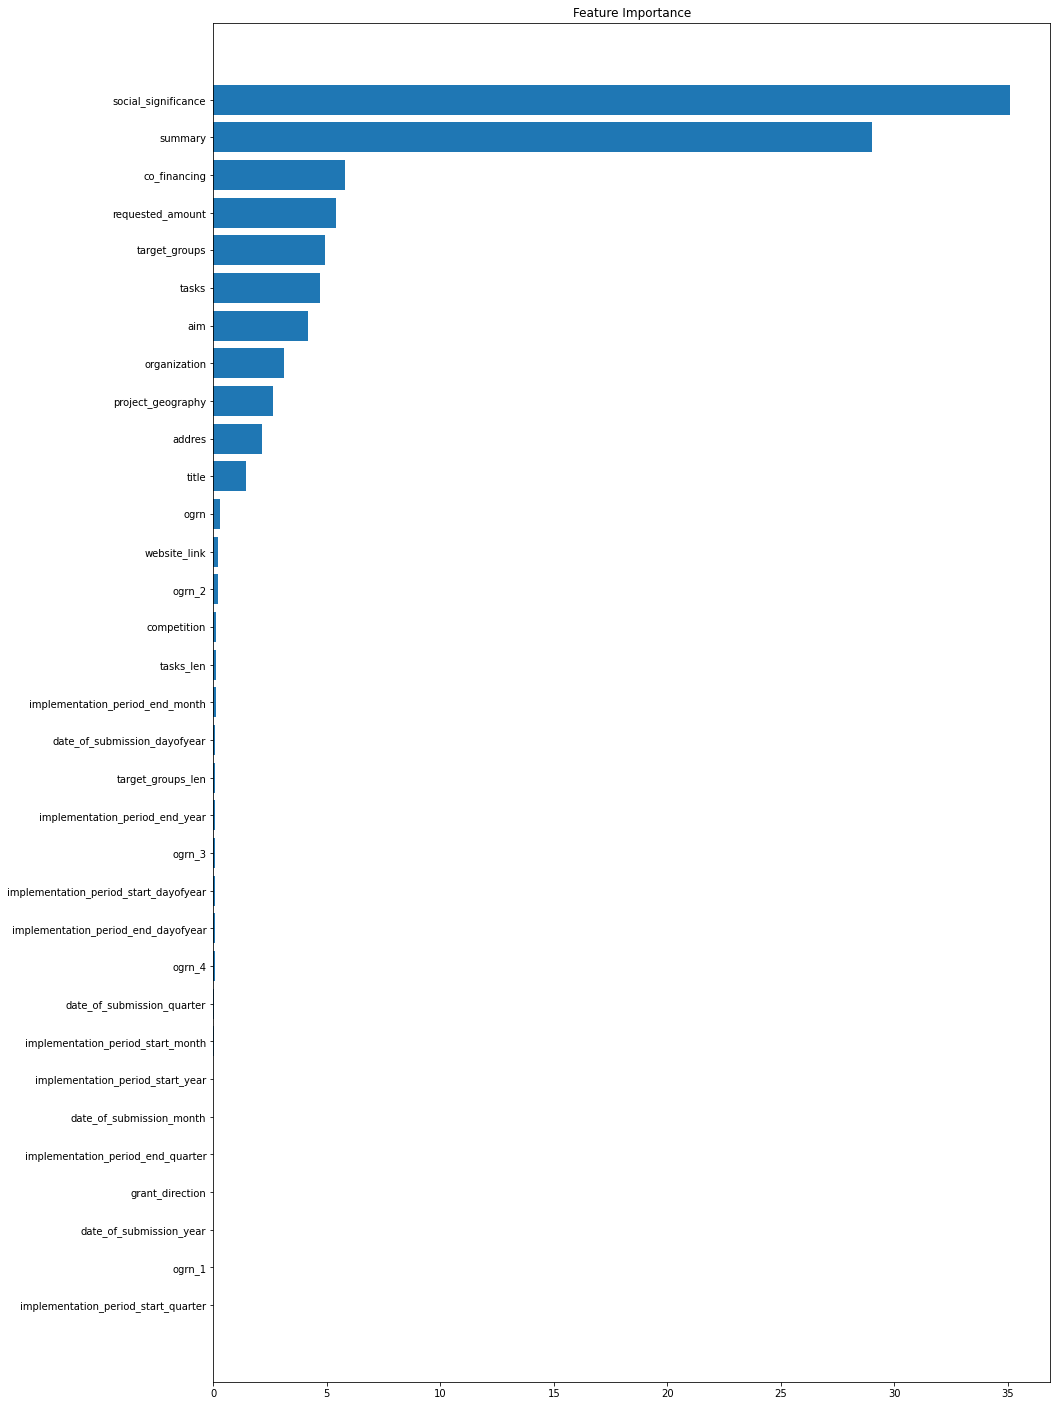

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15, 25))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_features)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
from sklearn.metrics import f1_score, classification_report

In [ ]:
t = pd.DataFrame({'y_true': val[y_feature].copy(), 
                  'y_pred': model.predict(val[X_features]),
                  'y_score': model.predict_proba(val[X_features])[:,1]})

In [ ]:
print(classification_report(t['y_true'],t['y_pred']))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89      2268
           1       0.57      0.05      0.10       576

    accuracy                           0.80      2844
   macro avg       0.69      0.52      0.49      2844
weighted avg       0.76      0.80      0.73      2844



In [ ]:
t

,y_true,y_pred,y_score
4836,0,0,0.034424
2414,0,0,0.134840
1368,0,0,0.152878
620,0,0,0.118863
6184,1,0,0.076816
...,...,...,...
3913,1,1,0.539536
1651,0,0,0.136899
1169,0,0,0.250482
3529,0,0,0.034845


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
fpr, tpr, thr = roc_curve(t['y_true'],t['y_score'])
roc = pd.DataFrame({'fpr':fpr,'tpr':tpr,'thr':thr})

In [ ]:
roc['random'] = roc['fpr'].copy()

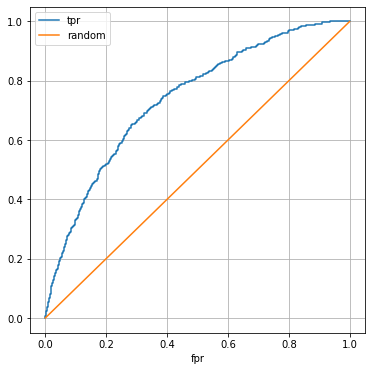

In [ ]:
roc.plot(x='fpr',y=['tpr','random'],figsize=(6,6),grid=True)

In [ ]:
from sklearn.metrics import auc

In [ ]:
auc(roc['fpr'],roc['tpr'])

0.7377936385459534

In [ ]:
roc

,fpr,tpr,thr,random
0,0.000000,0.000000,1.848465,0.000000
1,0.000441,0.000000,0.848465,0.000441
2,0.000441,0.006944,0.693388,0.000441
3,0.001323,0.006944,0.665408,0.001323
4,0.001323,0.008681,0.661683,0.001323
...,...,...,...,...
803,0.921517,0.996528,0.060881,0.921517
804,0.921517,0.998264,0.060805,0.921517
805,0.935626,0.998264,0.056083,0.935626
806,0.935626,1.000000,0.055823,0.935626


In [ ]:
# поиск оптимального порога
thr = roc.sort_values('tpr - fpr', ascending=False).iloc[0]['thr']
roc.sort_values('tpr - fpr', ascending=False)

,fpr,tpr,thr,random,tpr - fpr
458,0.283951,0.652778,0.197175,0.283951,0.368827
456,0.283069,0.651042,0.197472,0.283069,0.367973
454,0.282187,0.649306,0.197716,0.282187,0.367119
457,0.283951,0.651042,0.197220,0.283951,0.367091
455,0.283069,0.649306,0.197582,0.283069,0.366237
...,...,...,...,...,...
2,0.000441,0.006944,0.693388,0.000441,0.006504
3,0.001323,0.006944,0.665408,0.001323,0.005622
0,0.000000,0.000000,1.848465,0.000000,0.000000
807,1.000000,1.000000,0.021419,1.000000,0.000000


In [ ]:
t['y_pred_thr'] = (t['y_score'] > thr)*1

In [ ]:
print(classification_report(t['y_true'],t['y_pred_thr']))

              precision    recall  f1-score   support

           0       0.89      0.72      0.79      2268
           1       0.37      0.65      0.47       576

    accuracy                           0.70      2844
   macro avg       0.63      0.68      0.63      2844
weighted avg       0.78      0.70      0.73      2844



# Гипотезы

**Проверка корреляции между скором модели и выставленным рейтингом**